# A Very Simple Attention Mechanism

This tutorial will demonstrate how we can use `ttnn` to create a simple, and naive attention mechanism to calculate context vectors from input embeddings. 

This code, like the Embeddings notebook has been adapted from  [Sebastian Raschka](https://github.com/rasbt)'s [LLMs-from-scratch](https://github.com/rasbt/LLMs-from-scratch) repository. Please check it out. He is a huge inspiration for the LLM-related work in this repo.


## Attention Mechanisms

In a previous tutorial, we had calculated some input embeddings with trainable weights. It is now time to put those embeddings to use by creating a simple attention mechanism.

So here's our first fact:
> Attention mechanisms start from an input vector sourced from the **input embeddings**.

As a reminder, the input embeddings tensors had a dimensions like: (B, C, D) where B is the batch size, while C is the dimension representing the context length, and D is the embedding dimension. This means that for every element in batch B, we have a tensor that is of C context length. Within an element within the C dimension, we have D number of elements representing embedding information. 

Yes, a lot of digest, but we can break it down further in this notebook.

To create a _very simple_ attention mechansim, we'll need some terminology.

1. A _query_ is the vector given some token in context within input embeddings tensor. Essentially it is the corresponding embeddings vector across the D dimension for a given token. We can call this `q_i`, where `i` is the ith element in the input embeddings tensor.
2. An **attention score** is the result of the dot product between the given query's embedding vector against another token in the same context. We attention scores for all of the tokens in relative to the query. At the end the number of elements in the attention score vector is value of dimension C.
3. The **attention weight** is just the normalization of attention scores. Within the entire context row, all elements should sum to 1.0.
4. The **context vector** is the result of the matrix multiplication between the attention weights and the input embeddings.

## Dependencies and Setup

We'll first start with a `torch`-only implementation. Once we the basic approach figured out, we can do the same exercise, but with `ttnn`. 

First thing's first, let's import `torch`, set a manual seed and define a `batch`. This is the element at some index of dimension `B`. What results is a tensor of (C, D) shape. In this case, (6, 3). 

In [1]:
import torch
torch.manual_seed(123)

context = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

context.shape

torch.Size([6, 3])

## Selecting an Item for Query

Given our `context`, we would like to compute for the second token in there. This corresponds to the word `journey`. 

The selected token in which we want to compute the attention for is called the `query`.

In [2]:
query_3 = context[1] # select the second token in the context
query_3

tensor([0.5500, 0.8700, 0.6600])

## Attention Scores

We will compute the attention scores first by taking the dot product of the query against all other tokens and their values across the embedding dimension. 

The resulting length of the attn_scores will match the context length.

In [3]:
attn_scores = torch.empty(len(context))
for i, t_i in enumerate(context):
  attn_scores[i] = torch.dot(query_3, t_i)

attn_scores

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])

## Attention Weights

Next, we normalize the attention scores by using `softmax`. This becomes the attention weights.

In [4]:
# now we can take ths and softmax across the last dimension
attn_weights = torch.softmax(attn_scores, dim=-1)
attn_weights

tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])

We can check to see if the weights sum up to 1

In [5]:
# did it sum to 1?
attn_weights.sum()

tensor(1.)

## Context Vector

We'll now compute the context vector in relation to the query. We just multiply each attention weight with the corresponding token value within the existing context.

In [6]:
# now lets take teh context vector
context_vec = torch.zeros(len(query_3))
for i, c_i in enumerate(context):
  context_vec += attn_weights[i] * c_i

context_vec

tensor([0.4419, 0.6515, 0.5683])

That's it, that's how we compute the context vector for a single token. Can we generalize this across the entire context for other elements?

## Context Vector for All Tokens in Context

We will just need to take the matrix multiplication of the tensor in context and its transposed form. This is equivalent to performing the dot product of a query and the rest of the tokens in context.

In [7]:
# generalize the attention weights
attn_scores = context @ context.T

attn_scores

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])

Normalization is easy, just again, apply `softmax` across the last dimension of the attention weights.

In [8]:
attn_weights = torch.softmax(attn_scores, dim=-1)

attn_weights

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])

Last, we'll find the context vectors by performing a matrix multiplication of the attention weights and all tokens in context.

In [9]:
context_vecs = attn_weights @ context
context_vecs

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])

## Context Vector in tt-nn

It's time to do this same exercise but now using the `ttnn` library.

In [10]:
import os
os.environ["TTNN_CONFIG_OVERRIDES"] = "{\"enable_fast_runtime_mode\": false}"

As before, we import all our dependencies, and create a context for testing.

In [11]:
import torch
import ttnn
from ttnn.tracer import trace, visualize

torch.manual_seed(123)

context = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

context.shape


2025-04-20 16:50:25.284 | DEBUG    | ttnn:<module>:80 - Loading ttnn configuration overrides from environment variable TTNN_CONFIG_OVERRIDES
2025-04-20 16:50:25.285 | DEBUG    | ttnn:<module>:83 - Initial ttnn.CONFIG:
Config{cache_path=/home/avgdev/.cache/ttnn,model_cache_path=/home/avgdev/.cache/ttnn/models,tmp_dir=/tmp/ttnn,enable_model_cache=false,enable_fast_runtime_mode=false,throw_exception_on_fallback=false,enable_logging=false,enable_graph_report=false,enable_detailed_buffer_report=false,enable_detailed_tensor_report=false,enable_comparison_mode=false,comparison_mode_should_raise_exception=false,comparison_mode_pcc=0.9999,root_report_path=generated/ttnn/reports,report_name=std::nullopt,std::nullopt}


torch.Size([6, 3])

We'll need to create `ttnn` tensors of both context and the transposed version of it. Note that the hardware in the Tenstorrent device will read in the data as `bfloat16`. Some precision changes will occur.

2025-04-20 16:50:26.765 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None
2025-04-20 16:50:26.768 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None


                 Always | INFO     | Begin op: tt::tt_metal::detail::convert_python_tensor_to_tt_tensor
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<pybind11::handle const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::DataType>>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::Layout>>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::Tile> const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::MemoryConfig const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::IDevice*>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<bool const>
            

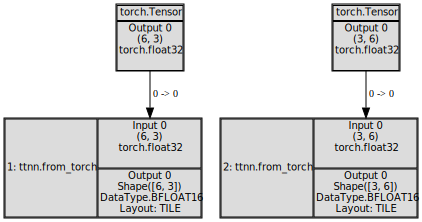

In [12]:
with trace():
  context_ttnn = ttnn.from_torch(context, dtype=ttnn.bfloat16, layout=ttnn.TILE_LAYOUT)
  context_transposed_ttnn = ttnn.from_torch(context.T, dtype=ttnn.bfloat16, layout=ttnn.TILE_LAYOUT)

visualize(context_ttnn)
visualize(context_transposed_ttnn)

At this point, we have everything set up to compute the context vectors. The steps are:
1. Transfer the context and transposed context to the device
2. Compute the attention scores using `ttnn.matmul`. Assume both the context and context transposed are already in `TILE_LAYOUT`.
3. Perform softmax on the resulting matrix of (2)
4. Compute the context vectors using `ttnn.matmul` against the attention weights and context in hardware.
5. Transfer the context vectors back to the host


In [13]:
device_id = 0
device = ttnn.open_device(device_id=device_id)

with trace():
  context_ttnn = ttnn.to_device(context_ttnn, device)
  context_transposed_ttnn = ttnn.to_device(context_transposed_ttnn, device)

  attn_scores_ttnn = ttnn.matmul(context_ttnn, context_transposed_ttnn)
  attn_weights_ttnn = ttnn.softmax(attn_scores_ttnn, dim=-1)

  context_vecs_ttnn = ttnn.matmul(attn_weights_ttnn, context_ttnn)

  context_vecs_ttnn_host = ttnn.from_device(context_vecs_ttnn)

ttnn.close_device(device)

context_vecs_ttnn_host

                 Device | INFO     | Opening user mode device driver
2025-04-20 16:50:28.438 | INFO     | SiliconDriver   - Opened PCI device 0; KMD version: 1.33.0, IOMMU: disabled

2025-04-20 16:50:28.449 | INFO     | SiliconDriver   - Opened PCI device 0; KMD version: 1.33.0, IOMMU: disabled
2025-04-20 16:50:28.451 | INFO     | SiliconDriver   - Harvesting mask for chip 0 is 0x200 (physical layout: 0x1, logical: 0x200, simulated harvesting mask: 0x0).
2025-04-20 16:50:28.451 | INFO     | SiliconDriver   - Opened PCI device 0; KMD version: 1.33.0, IOMMU: disabled
2025-04-20 16:50:28.452 | INFO     | SiliconDriver   - Detected PCI devices: [0]
2025-04-20 16:50:28.452 | INFO     | SiliconDriver   - Using local chip ids: {0} and remote chip ids {}
2025-04-20 16:50:28.478 | INFO     | SiliconDriver   - Software version 6.0.0, Ethernet FW version 6.14.0 (Device 0)
                  Metal | INFO     | Initializing device 0. Program cache is NOT enabled
                  Metal | INFO     | 

New chip! We now have 1 chips
Chip initialization complete (found )
Chip initializing complete...
 ARC

 [4/4] DRAM

 [16/16] ETH

 CPU

Chip detection complete (found )


ttnn.Tensor([[ 0.44141,  0.58984,  0.57812],
             [ 0.43359,  0.64844,  0.56641],
             ...,
             [ 0.46094,  0.58594,  0.52344],
             [ 0.41602,  0.64844,  0.55859]], shape=Shape([6, 3]), dtype=DataType::BFLOAT16, layout=Layout::TILE)

Below visualizes the entire workflow.

2025-04-20 16:50:32.114 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None


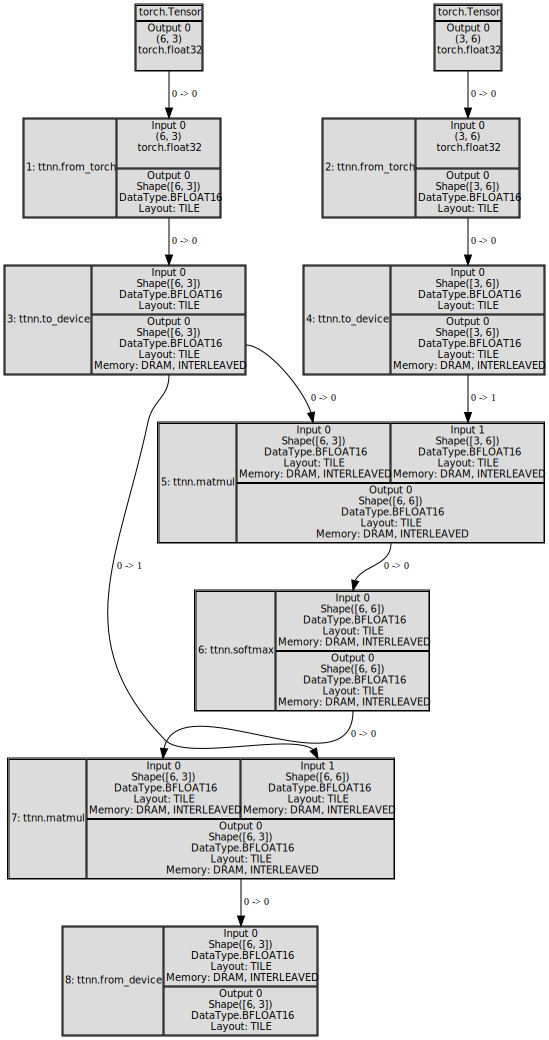

In [14]:
visualize(context_vecs_ttnn_host)

Notice the slight difference between the context vectors on `ttnn` compared to `torch`.

In [15]:
context_vecs_ttnn_host

ttnn.Tensor([[ 0.44141,  0.58984,  0.57812],
             [ 0.43359,  0.64844,  0.56641],
             ...,
             [ 0.46094,  0.58594,  0.52344],
             [ 0.41602,  0.64844,  0.55859]], shape=Shape([6, 3]), dtype=DataType::BFLOAT16, layout=Layout::TILE)

In [16]:
context_vecs

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])